# Maestría en Ciencia de Datos - Fundamentos de Analítica II
## Daniel Martínez Villegas - Felipe Montenegro Fuentes 
### Taller II

# 1. Librerías

In [1]:
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 2. Carga de Datos

In [2]:
data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


# 3. Protocolo de Evaluación

In [3]:
# Se lleva acabo la división de lso datos en conjunto de entrenamiento y datos de prueba, para ello nos enfocaremos en los datos de ocupados. 

train_socupados = data[["Ocupados"]][:len(data)-6] #Se está tomando todos los datos menos los 10 últimos
test_socupados = data[["Ocupados"]][len(data)-6:len(data)] #Se están tomando los restantes

In [4]:
print(test_socupados)

             Ocupados
mes                  
2018-11-01  10783.299
2018-12-01  10835.398
2019-01-01  10314.438
2019-02-01  10557.917
2019-03-01  10760.776
2019-04-01  10632.028


Una vez realizado el protocolo de evaluación, el objetivo de este ejercicio es evaluar diferentes combinaciones de modelos para estimar la tendencia y la estacionalidad de la serie de ocupados de los datos provistos por el DANE. Para ello vamos a generar inicialmente una función que nos permita evaluar la tendencia de la serie usando tres ordenes: 

- Lineal
- Cuadrática 
- Polinómica

# Generación de la función

In [5]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd

def fit_polynomial_model(order, train_data, test_data, h=6):
    # Paso 1: Definir las variables independientes y dependientes
    y = train_data
    x = np.linspace(1, len(train_data), len(train_data))
    
    # Generar las características polinómicas
    X = np.vander(x, N=order+1, increasing=True)
    
    # Ajustar el modelo
    model = sm.OLS(y, X)
    model_fit = model.fit()
    print(f"Resumen del modelo de orden {order}:")
    print(model_fit.summary())

    # Paso 2: Graficar los residuos del modelo
    print("Los residuos del modelo son los siguientes:")
    plt.figure(figsize=(10, 6))
    plt.ylabel("Residuales del modelo")
    plt.plot(model_fit.resid)
    plt.grid()
    plt.show()
    
    # Paso 3: Graficar la tendencia ajustada vs. la serie original
    print("Graficamos la serie original y la tendencia")
    plt.figure(figsize=(10, 6))
    plt.plot(y, label="Ocupados")
    plt.plot(model_fit.fittedvalues, label=f"Tendencia de Orden {order}")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Paso 4: Pronóstico para h periodos
    x_for = np.linspace(len(train_data) + 1, len(train_data) + h, h)
    X_for = np.vander(x_for, N=order+1, increasing=True)
    
    # Obtener los pronósticos con intervalos de confianza
    dt = model_fit.get_prediction(X_for).summary_frame(alpha=0.05)
    y_prd = dt['mean']
    yprd_ci_lower = dt['obs_ci_lower']
    yprd_ci_upper = dt['obs_ci_upper']
    
    preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
    preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
    
    print("Realizamos el pronóstico para un horizonte de 6 periodos")
    print(preds)
    
    # Paso 5: Gráfica de los datos de entrenamiento y los pronósticos
    print("Graficamos la serie original y el pronóstico estimado para los próximos 6 meses")
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, label="Datos Entrenamiento")
    plt.plot(x_for, preds['Point_forecast'], label=f"Tendencia de Orden {order}")
    plt.fill_between(x_for, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
    plt.legend()
    plt.show()

    # Paso 6: Cálculo del RMSE
    rmse = np.sqrt(mean_squared_error(test_data, preds['Point_forecast']))
    print(f"RMSE - Modelo de Orden {order}: {rmse}")
    
    return model_fit, preds, rmse

# 4. Modelo - Tendencia Lineal

Resumen del modelo de orden 1:
                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     5439.
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          4.10e-153
Time:                        19:11:39   Log-Likelihood:                -1483.6
No. Observations:                 214   AIC:                             2971.
Df Residuals:                     212   BIC:                             2978.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6916.5808

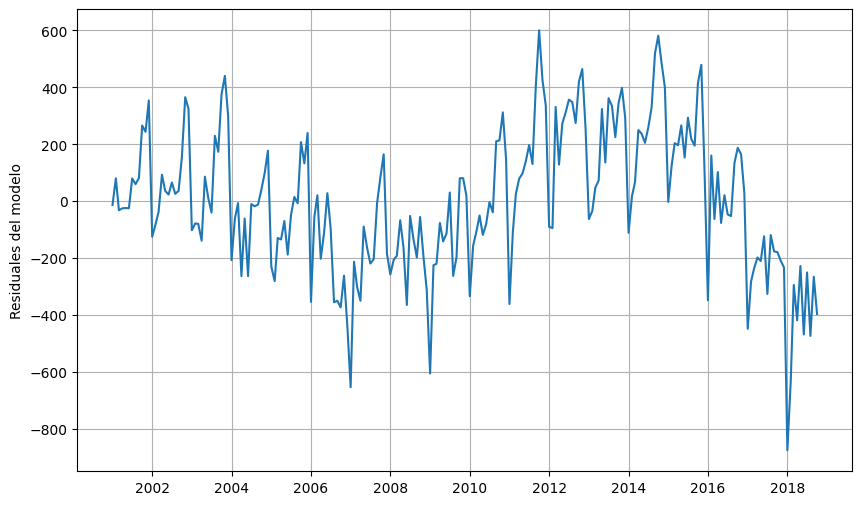

Graficamos la serie original y la tendencia


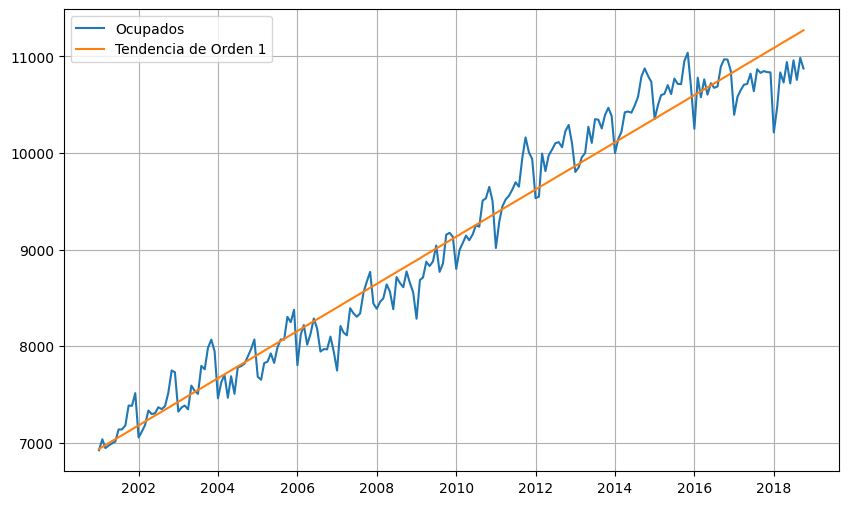

Realizamos el pronóstico para un horizonte de 6 periodos
   Point_forecast      lower_95      upper_95
0    11290.562073  10794.552484  11786.571663
1    11310.906172  10814.832205  11806.980139
2    11331.250271  10835.111339  11827.389204
3    11351.594370  10855.389885  11847.798855
4    11371.938469  10875.667843  11868.209094
5    11392.282568  10895.945215  11888.619920
Graficamos la serie original y el pronóstico estimado para los próximos 6 meses


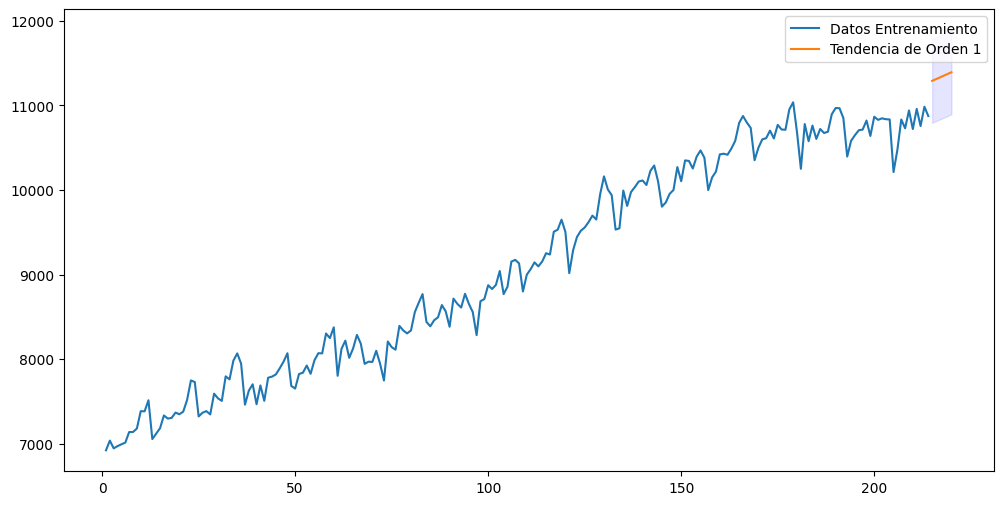

RMSE - Modelo de Orden 1: 718.651675100178


In [6]:
model_fit_lin, preds_lin, rmse_lin = fit_polynomial_model(order=1, train_data=train_socupados, test_data=test_socupados)

# 4.2 Modelo de Tendencia Cuadrática

Resumen del modelo de orden 2:
                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     2750.
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          7.46e-152
Time:                        19:11:40   Log-Likelihood:                -1482.0
No. Observations:                 214   AIC:                             2970.
Df Residuals:                     211   BIC:                             2980.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6846.9680

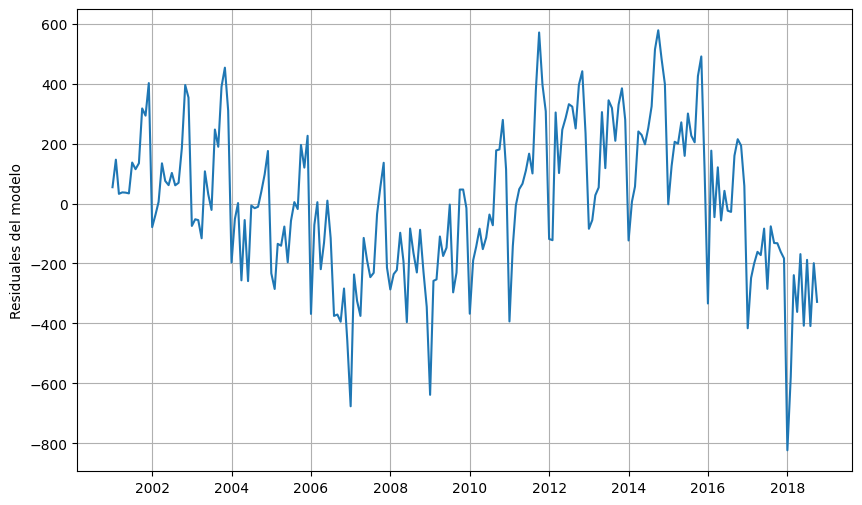

Graficamos la serie original y la tendencia


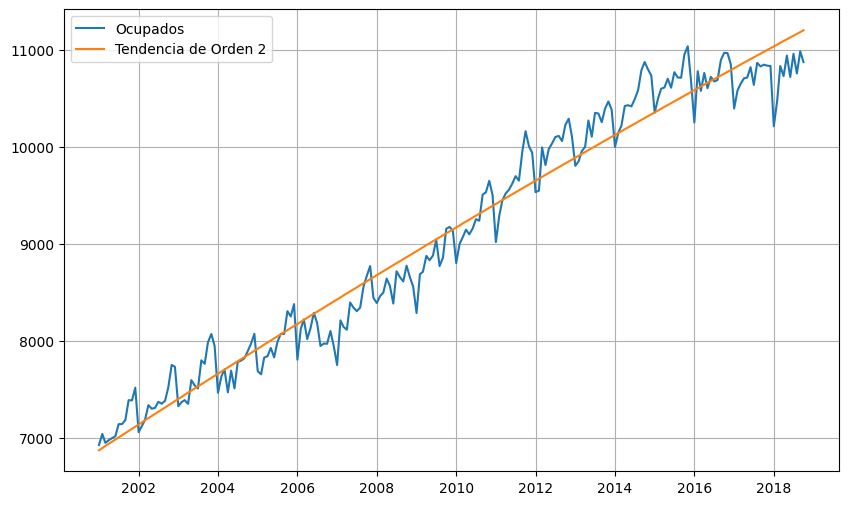

Realizamos el pronóstico para un horizonte de 6 periodos
   Point_forecast      lower_95      upper_95
0    11220.949257  10721.787967  11720.110547
1    11239.350672  10739.800787  11738.900558
2    11257.734100  10757.783260  11757.684941
3    11276.099540  10775.735164  11776.463916
4    11294.446992  10793.656279  11795.237705
5    11312.776457  10811.546382  11814.006531
Graficamos la serie original y el pronóstico estimado para los próximos 6 meses


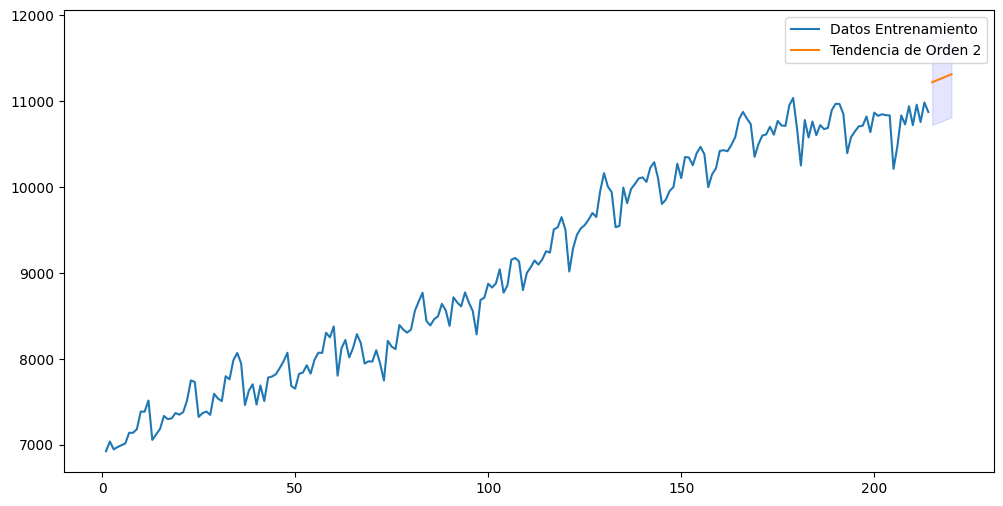

RMSE - Modelo de Orden 2: 646.5978131673129


In [7]:
model_fit_quad, preds_quad, rmse_quad = fit_polynomial_model(order=2, train_data=train_socupados, test_data=test_socupados)

# 4.3 Modelo - Tendencia Polinómica 

Resumen del modelo de orden 3:
                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2873.
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          3.73e-170
Time:                        19:11:40   Log-Likelihood:                -1434.9
No. Observations:                 214   AIC:                             2878.
Df Residuals:                     210   BIC:                             2891.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7246.7790

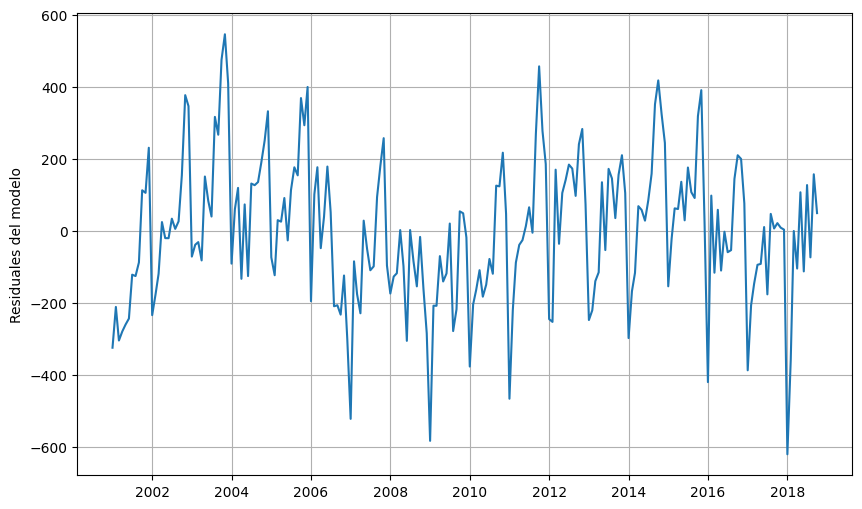

Graficamos la serie original y la tendencia


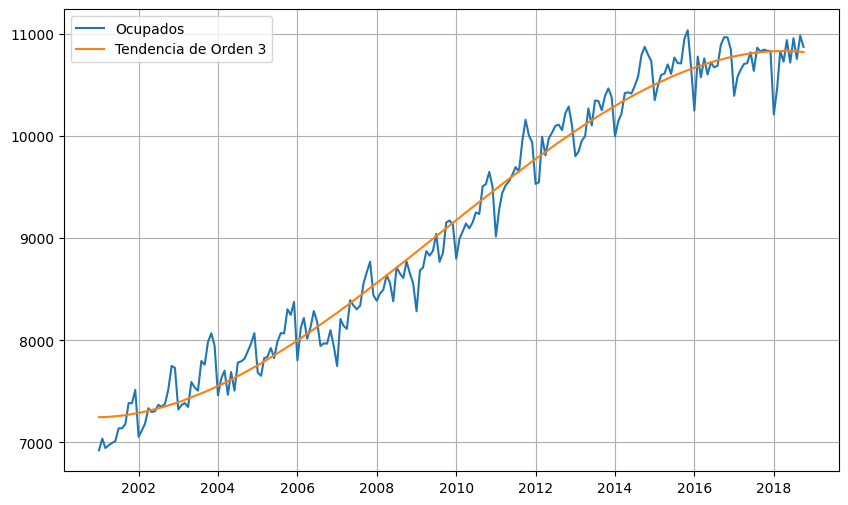

Realizamos el pronóstico para un horizonte de 6 periodos
   Point_forecast      lower_95      upper_95
0    10821.138290  10413.038112  11229.238468
1    10817.224675  10408.066442  11226.382908
2    10812.776520  10402.493637  11223.059404
3    10807.789065  10396.312228  11219.265902
4    10802.257549  10389.514708  11215.000391
5    10796.177211  10382.093533  11210.260890
Graficamos la serie original y el pronóstico estimado para los próximos 6 meses


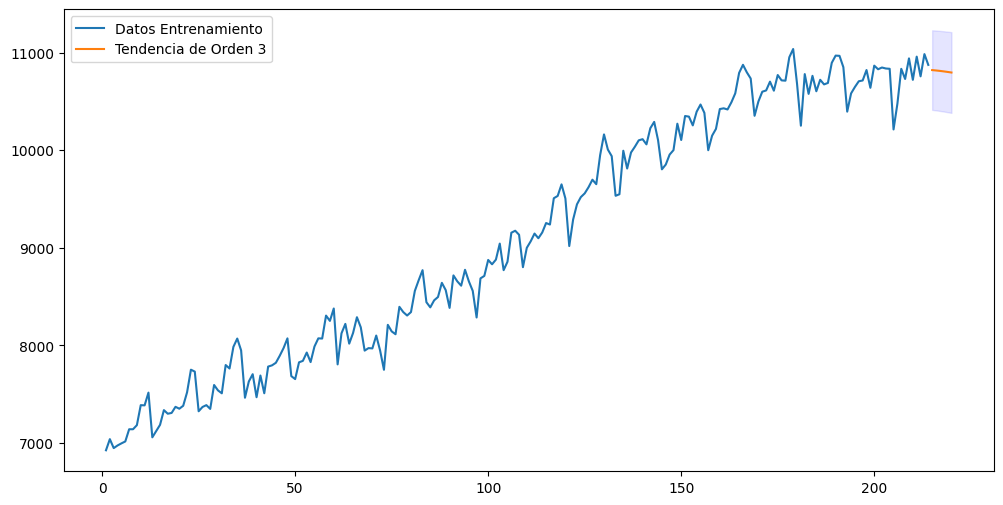

RMSE - Modelo de Orden 3: 238.4691083636837


In [8]:
model_fit_cubic, preds_cubic, rmse_cubic = fit_polynomial_model(order=3, train_data=train_socupados, test_data=test_socupados)

A continuación, procedemos a estimar la estacionalidad de la serie.

# 5. Estimación de Estacionalidad

In [9]:
month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index)
month_dummies = month_dummies.astype(float)

y = data["Ocupados"]
X = sm.add_constant(month_dummies)
sea = sm.OLS(y,X)
season = sea.fit()
print(season.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.2787
Date:                Wed, 14 Aug 2024   Prob (F-statistic):              0.989
Time:                        19:11:40   Log-Likelihood:                -1886.0
No. Observations:                 220   AIC:                             3796.
Df Residuals:                     208   BIC:                             3837.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8808.2176    301.805     29.185      0.0

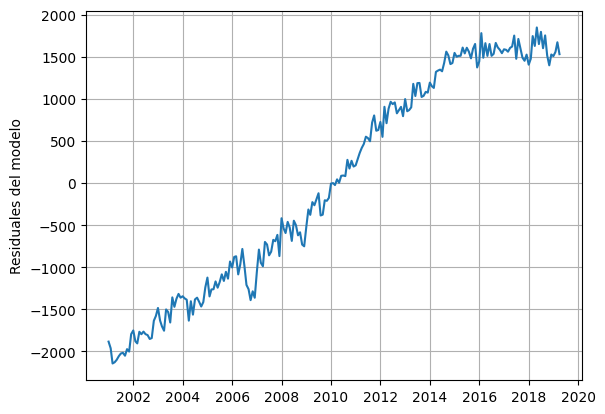

In [10]:
plt.ylabel("Residuales del modelo")
plt.plot(season.resid)
plt.grid()

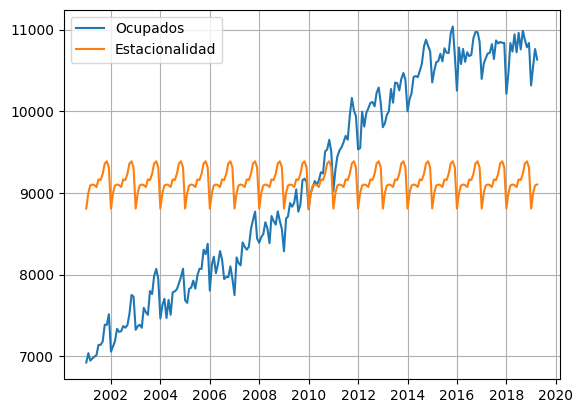

In [11]:
plt.plot(y,label="Ocupados")
plt.plot(season.fittedvalues,label="Estacionalidad")
plt.legend()
plt.grid()
plt.show()

In [12]:
range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=12,freq='MS')

x_for = pd.get_dummies(range_dates.month,drop_first=True)
X_for= sm.add_constant(x_for)

In [13]:
print(x_for.dtypes)
print(X_for.dtypes)

'''Los datos en x_for y X_for contienen columnas con el tipo bool y object,
que pueden estar causando problemas cuando intentas pasar estos datos a un modelo de statsmodels. 
El modelo espera datos numéricos (float64, int64, etc.) en lugar de datos booleanos u objetos.'''


2     uint8
3     uint8
4     uint8
5     uint8
6     uint8
7     uint8
8     uint8
9     uint8
10    uint8
11    uint8
12    uint8
dtype: object
const    float64
2          uint8
3          uint8
4          uint8
5          uint8
6          uint8
7          uint8
8          uint8
9          uint8
10         uint8
11         uint8
12         uint8
dtype: object


'Los datos en x_for y X_for contienen columnas con el tipo bool y object,\nque pueden estar causando problemas cuando intentas pasar estos datos a un modelo de statsmodels. \nEl modelo espera datos numéricos (float64, int64, etc.) en lugar de datos booleanos u objetos.'

In [14]:
x_for = x_for.apply(lambda x: x.astype(int))
X_for = sm.add_constant(x_for)


In [15]:
print(X_for.dtypes)


const    float64
2          int64
3          int64
4          int64
5          int64
6          int64
7          int64
8          int64
9          int64
10         int64
11         int64
12         int64
dtype: object


In [16]:
dt = season.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast     lower_95      upper_95
2019-05-01     9095.089000  6430.527026  11759.650974
2019-06-01     9071.789000  6407.227026  11736.350974
2019-07-01     9164.935167  6500.373193  11829.497140
2019-08-01     9156.633500  6492.071526  11821.195474
2019-09-01     9232.988500  6568.426526  11897.550474
2019-10-01     9359.934944  6695.372971  12024.496918
2019-11-01     9386.702222  6722.140249  12051.264196
2019-12-01     9310.332667  6645.770693  11974.894640
2020-01-01     8808.217632  6147.348746  11469.086517
2020-02-01     9001.037684  6340.168799  11661.906569
2020-03-01     9090.037158  6429.168273  11750.906043
2020-04-01     9102.647316  6441.778431  11763.516201


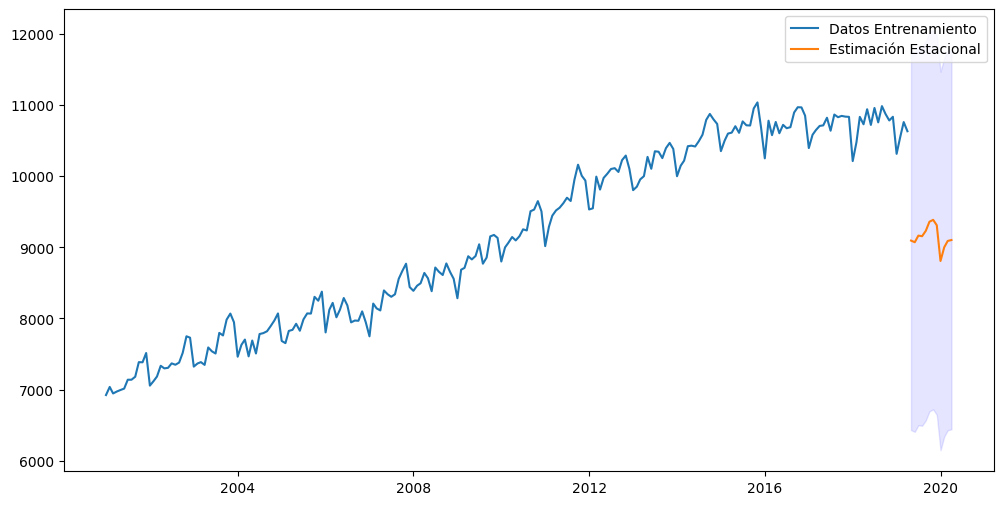

In [17]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [18]:
# Cálculo del RMSE

fitted_values = season.fittedvalues
errors = y - fitted_values
mse = np.mean(errors**2)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Guardar el RMSE en una variable
rmse_estacionalidad = rmse

RMSE: 1279.1551318629215


# 6. Combinación de los Modelos


- Tendencia Lineal + Estacionalidad 
- Tendencia Cuadrática + Estacionalidad
- Tendencia Polinómica + Estacinoalidad

### Tendencia lineal + estacionalidad

In [19]:
def fit_polynomial_model_with_seasonality(order, train_data, test_data=None, h=6):
    try:
        y = train_data.copy()
        x = np.linspace(1, len(train_data), len(train_data))
        X_poly = np.vander(x, N=order+1, increasing=True)
        
        month_dummies = pd.get_dummies(train_data.index.month, drop_first=True).set_index(train_data.index)
        
        # month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index)
        # month_dummies = month_dummies.astype(float)
        
        X_design = sm.add_constant(np.column_stack((X_poly, month_dummies)))
        
        model = sm.OLS(y, X_design)
        model_fit = model.fit()
        print(model_fit.summary())
        
        rmse_train = np.sqrt(mean_squared_error(y, model_fit.fittedvalues))
        
        plt.figure(figsize=(10, 5))
        plt.plot(model_fit.resid, label='Residuals')
        plt.ylabel("Residuals")
        plt.grid(True)
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        plt.plot(y, label="Actual")
        plt.plot(model_fit.fittedvalues, label="Fitted")
        plt.ylabel("Values")
        plt.title("Actual vs Fitted Values")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        x_for = np.linspace(len(train_data) + 1, len(train_data) + h, h)
        X_poly_for = np.vander(x_for, N=order+1, increasing=True)
        
        forecast_dates = pd.date_range(train_data.index[-1] + relativedelta(months=1), periods=h, freq='MS')
        month_dummies_for = pd.get_dummies(forecast_dates.month, drop_first=True)
        
        month_dummies_for = month_dummies_for.reindex(columns=month_dummies.columns, fill_value=0)
        
        X_for = sm.add_constant(np.column_stack((X_poly_for, month_dummies_for)))
        
        forecast_results = model_fit.get_prediction(X_for).summary_frame(alpha=0.05)
        preds = forecast_results[['mean', 'obs_ci_lower', 'obs_ci_upper']]
        preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
        preds.index = forecast_dates
        
        plt.figure(figsize=(10, 5))
        plt.plot(y.index, y, label="Historical Data")
        plt.plot(preds.index, preds['Point_forecast'], label="Forecast", color='blue')
        plt.fill_between(preds.index, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.2)
        plt.title("Forecast vs Actual")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        rmse_test = None
        if test_data is not None:
            y_test = test_data
            x_test = np.linspace(len(train_data) + 1, len(train_data) + len(test_data), len(test_data))
            X_poly_test = np.vander(x_test, N=order+1, increasing=True)
            month_dummies_test = pd.get_dummies(test_data.index.month, drop_first=True).reindex(columns=month_dummies.columns, fill_value=0)
            X_test = sm.add_constant(np.column_stack((X_poly_test, month_dummies_test)))
            y_pred_test = model_fit.predict(X_test)
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        
        return preds, rmse_train, rmse_test, model_fit
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None


                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     585.2
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          4.02e-149
Time:                        19:16:45   Log-Likelihood:                -1451.7
No. Observations:                 214   AIC:                             2929.
Df Residuals:                     201   BIC:                             2973.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6635.5874     57.739    114.923      0.0

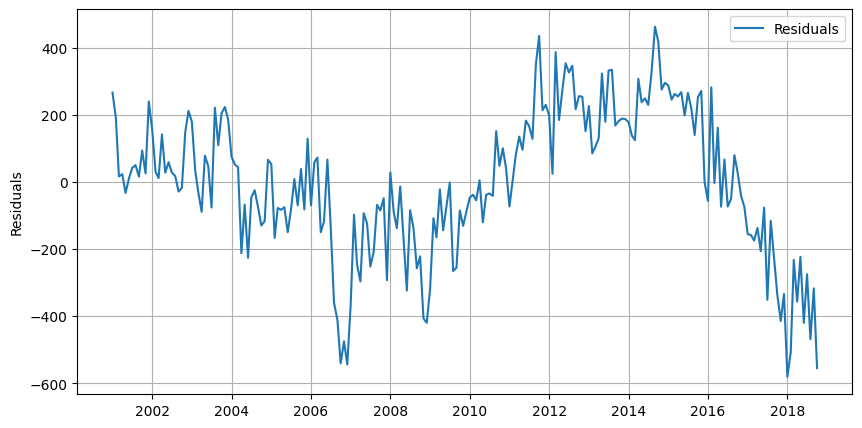

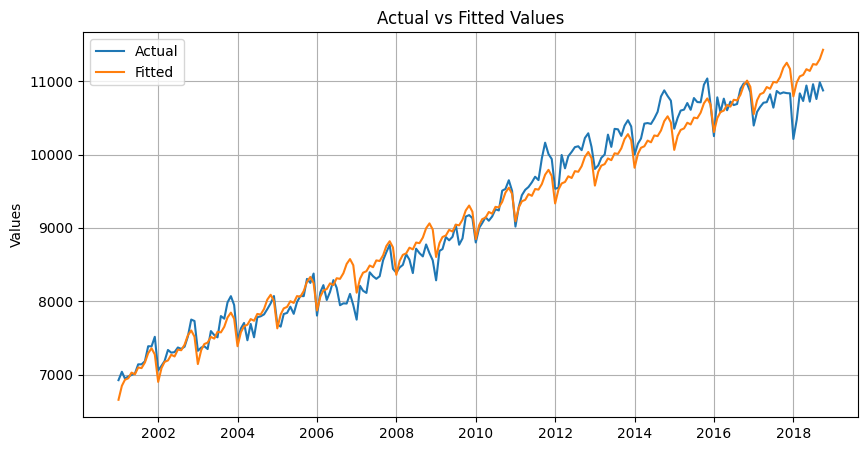

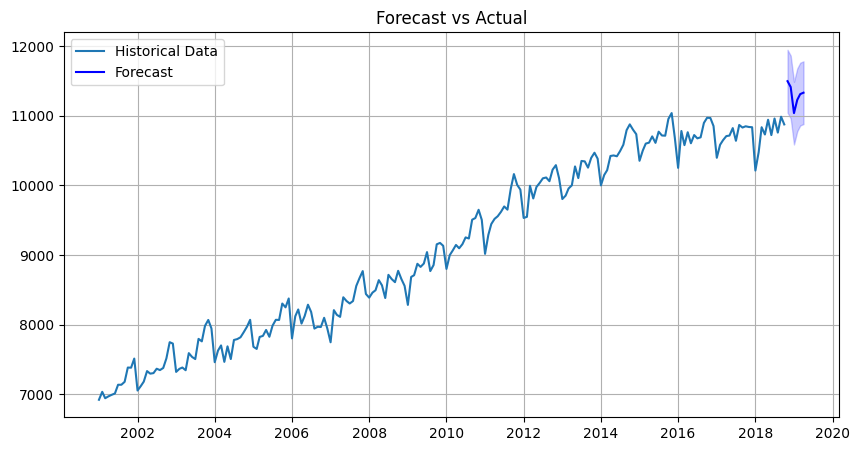

{'rmse_train_sta_order_1': 213.6959195516363, 'rmse_test_sta_order_1': 657.5089799828968}
                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     546.8
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          1.87e-148
Time:                        19:16:45   Log-Likelihood:                -1449.9
No. Observations:                 214   AIC:                             2928.
Df Residuals:                     200   BIC:                             2975.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

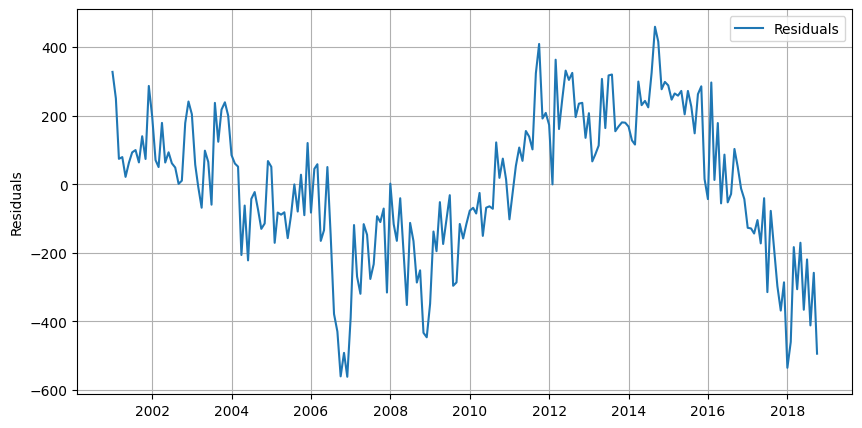

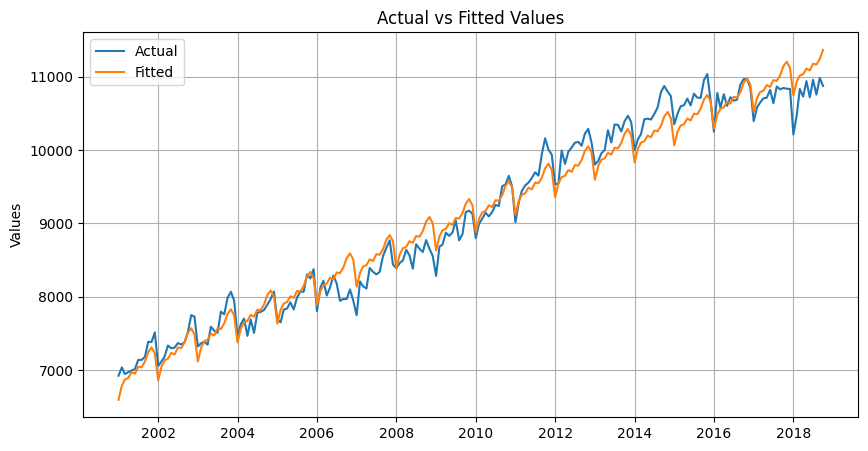

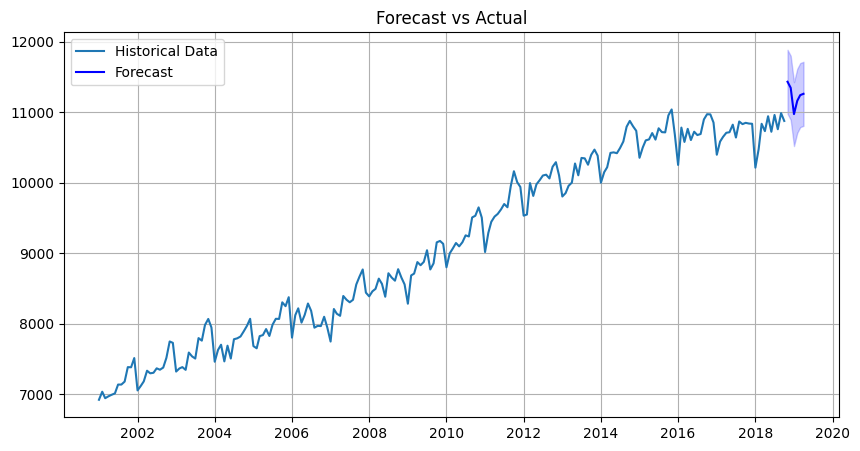

{'rmse_train_sta_order_2': 211.9149907756035, 'rmse_test_sta_order_2': 590.4794957118677}
                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1079.
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          3.41e-179
Time:                        19:16:45   Log-Likelihood:                -1370.3
No. Observations:                 214   AIC:                             2771.
Df Residuals:                     199   BIC:                             2821.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

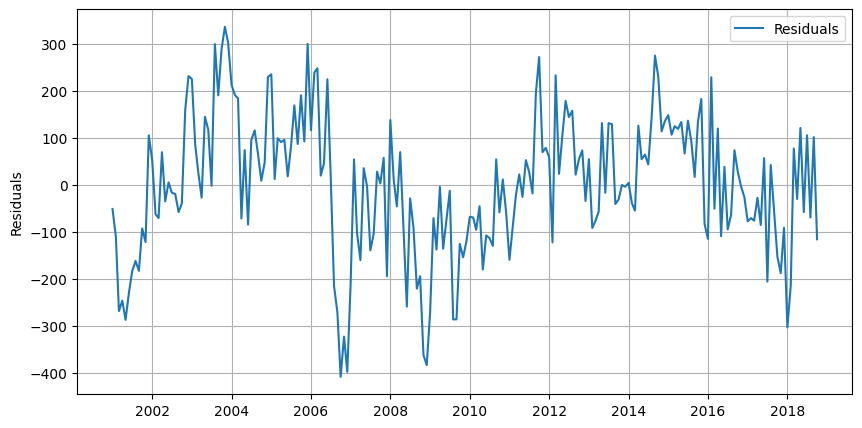

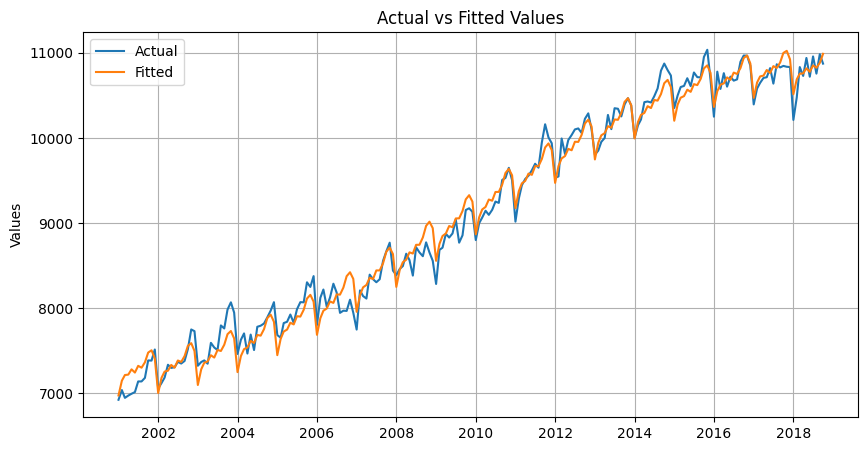

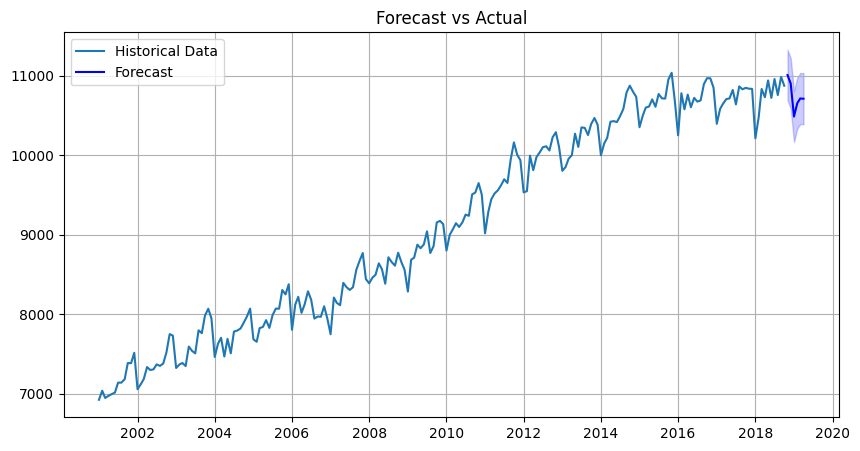

{'rmse_train_sta_order_3': 146.0769304789088, 'rmse_test_sta_order_3': 130.74393943447288}
                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1343.
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          4.06e-190
Time:                        19:16:45   Log-Likelihood:                -1339.3
No. Observations:                 214   AIC:                             2711.
Df Residuals:                     198   BIC:                             2764.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

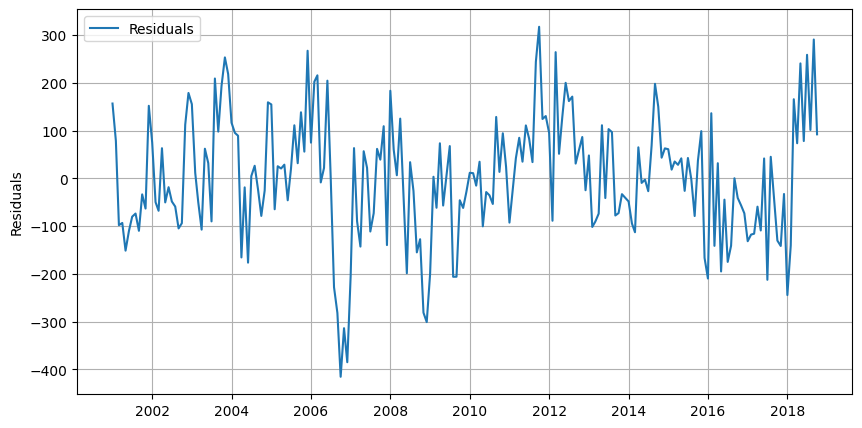

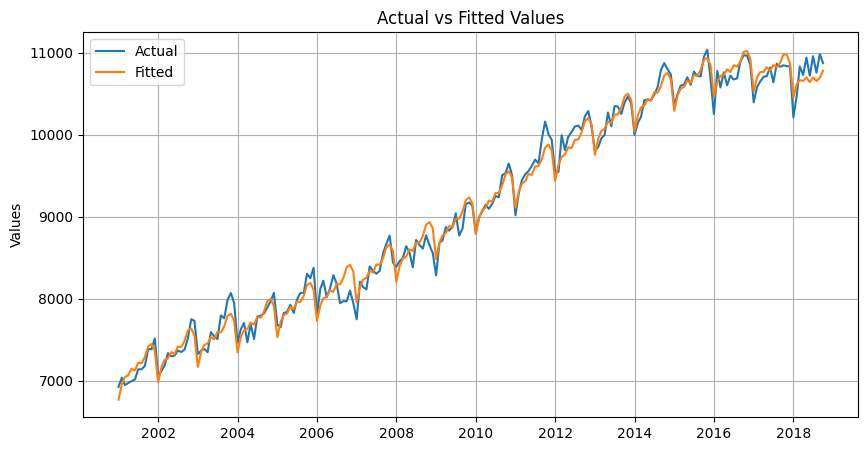

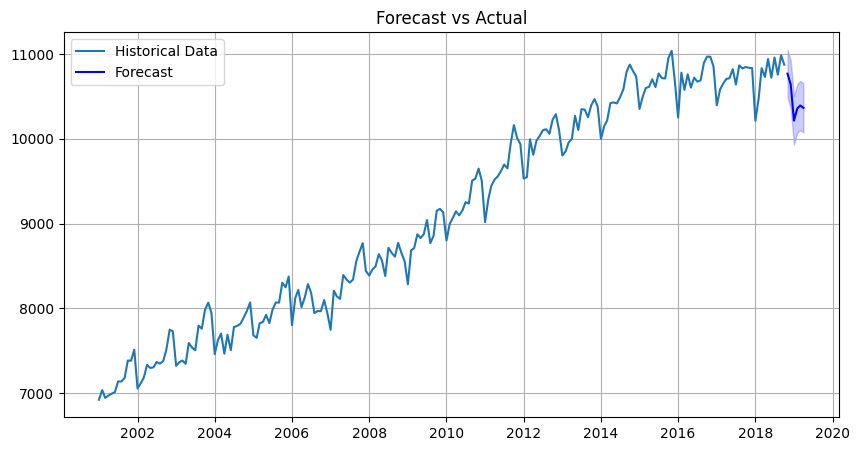

{'rmse_train_sta_order_4': 126.37549485149685, 'rmse_test_sta_order_4': 221.62202882374555}
                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1447.
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          1.19e-194
Time:                        19:16:46   Log-Likelihood:                -1324.0
No. Observations:                 214   AIC:                             2682.
Df Residuals:                     197   BIC:                             2739.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

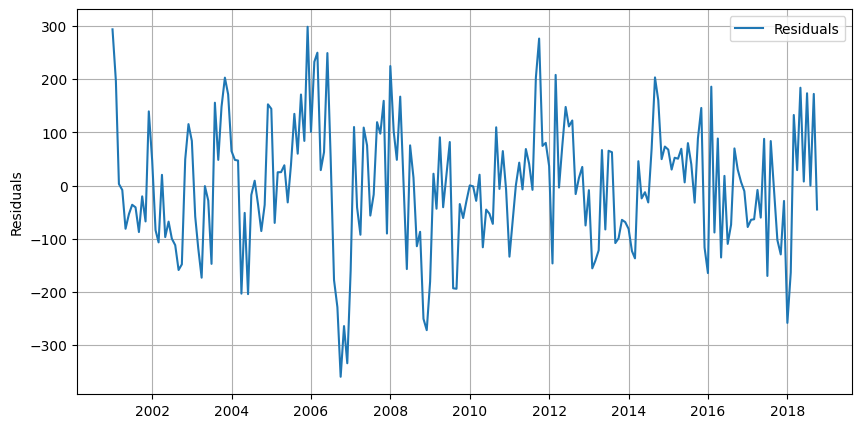

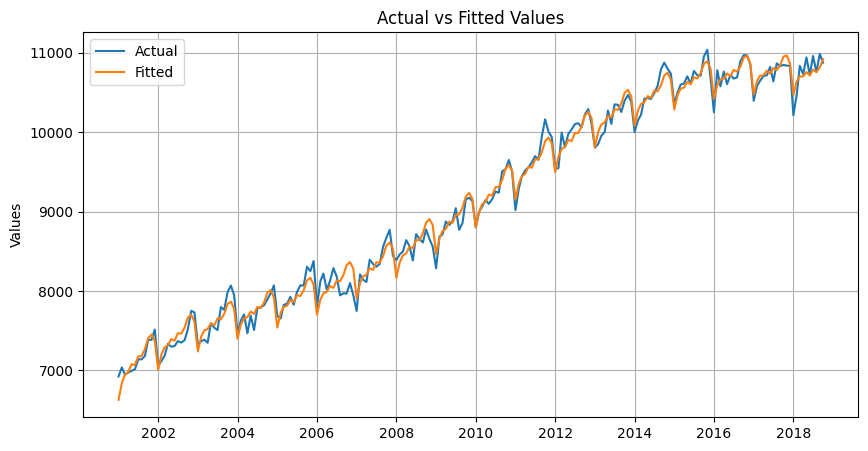

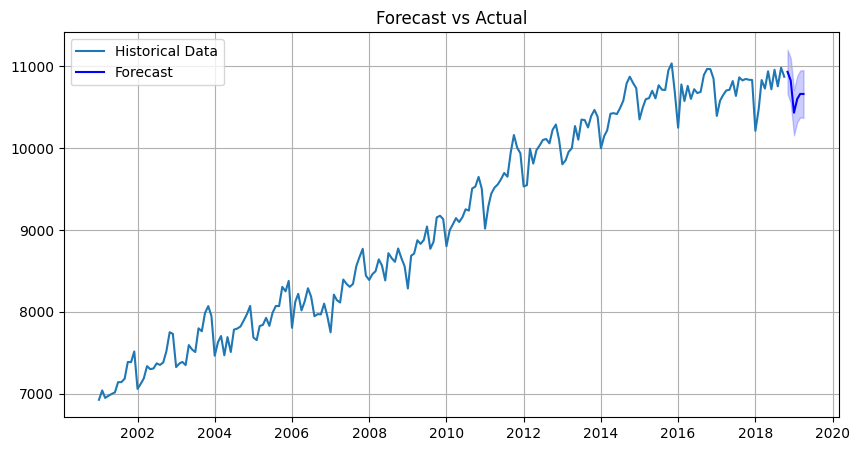

{'rmse_train_sta_order_5': 117.66734678534209, 'rmse_test_sta_order_5': 91.05810795857741}
                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1534.
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          3.98e-197
Time:                        19:16:46   Log-Likelihood:                -1317.8
No. Observations:                 214   AIC:                             2670.
Df Residuals:                     197   BIC:                             2727.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

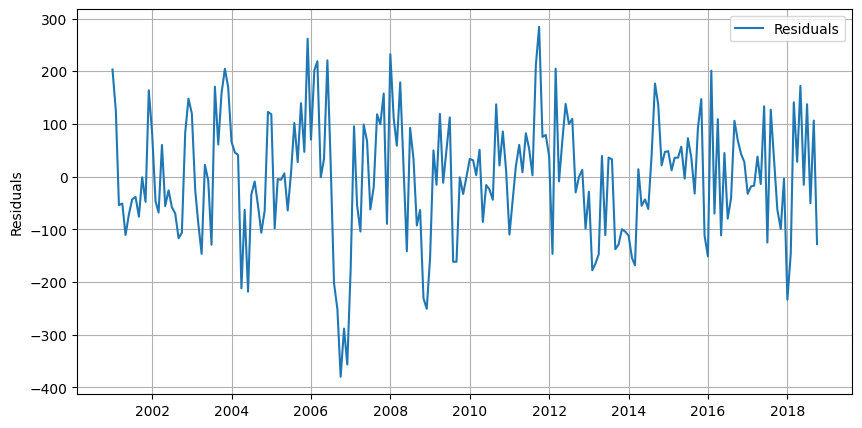

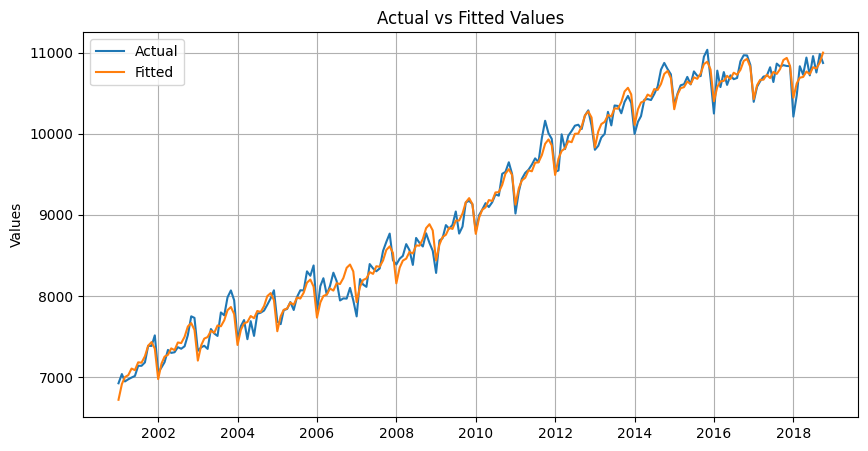

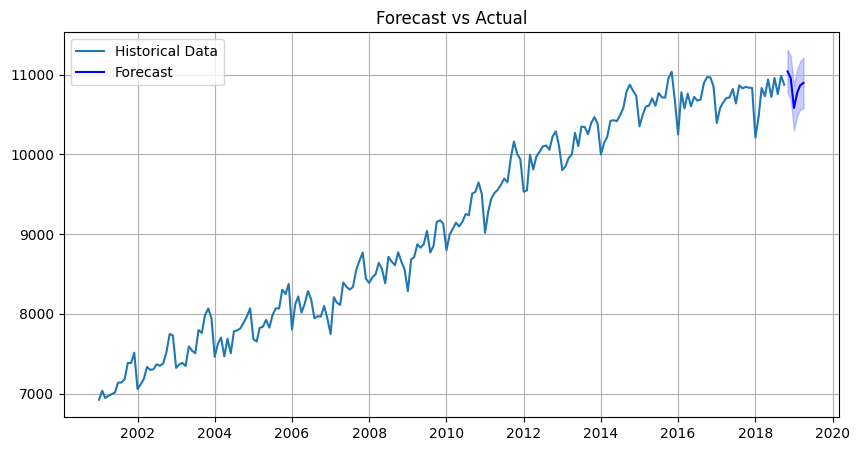

{'rmse_train_sta_order_6': 114.30881693079188, 'rmse_test_sta_order_6': 217.71646883354714}


In [25]:
results = {}
fitted_models = {}

for order in range(1, 7):

    preds, rmse_train, rmse_test, fitted_model  = fit_polynomial_model_with_seasonality(
        order=order,
        train_data=train_socupados,
        test_data=test_socupados,
        h=6
    )
    results[f"rmse_test_sta_order_{order}"] = rmse_test
    fitted_models[f"model_order_{order}"] = fitted_model
    
    print({
        f"rmse_train_sta_order_{order}": rmse_train,
        f"rmse_test_sta_order_{order}": rmse_test
    })




In [21]:
results = dict(sorted(results.items(), key=lambda item: item[1]))
results

{'rmse_test_sta_order_5': 91.05810795857741,
 'rmse_test_sta_order_3': 130.74393943447288,
 'rmse_test_sta_order_6': 217.71646883354714,
 'rmse_test_sta_order_4': 221.62202882374555,
 'rmse_test_sta_order_2': 590.4794957118677,
 'rmse_test_sta_order_1': 657.5089799828968}

# 7. Pronóstico utilizando el Mejor Modelo 

Previamente debemos evalular los RMSE para seleccionar el mejor modelo para predecir. En este punto debemos usar TODOS los datos.

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1529.
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          6.92e-202
Time:                        19:11:42   Log-Likelihood:                -1359.6
No. Observations:                 220   AIC:                             2753.
Df Residuals:                     203   BIC:                             2811.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6586.1092     56.850    115.852      0.0

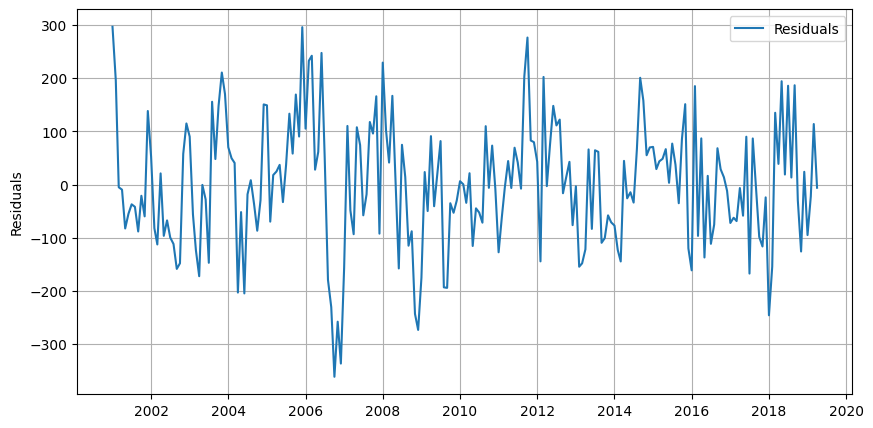

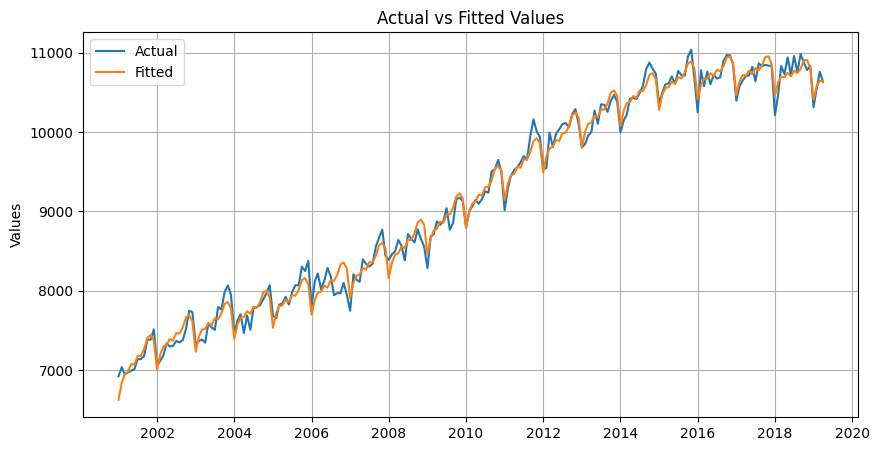

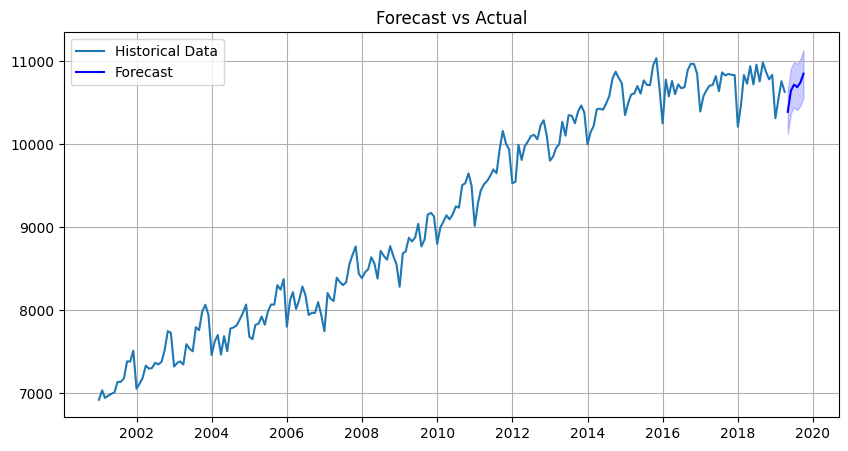

In [22]:
preds_best_model, _, _ ,model_final_fit = fit_polynomial_model_with_seasonality(
    order=5, 
    train_data=data[["Ocupados"]],
    test_data=None,
    h=6
)

# 8. Validación de Supuestos 

Debemos validar los supuestos enfocandos en los residuales del último modelo.

In [33]:
import statsmodels.stats.api as sms
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


def check_residuals_assumptions(model_fit):
    # Extract residuals
    residuals = model_fit.resid
    
    # 1. Autocorrelation - Durbin-Watson Test
    dw_stat = sm.stats.durbin_watson(residuals)
    print(f"Durbin-Watson Statistic: {dw_stat:.2f}")
    
    # 2. Homoscedasticity - Breusch-Pagan Test
    bp_test = sms.het_breuschpagan(residuals, model_fit.model.exog)
    print(f"Breusch-Pagan Test: p-value = {bp_test[1]:.4f}")
    
    # 3. Normality - Shapiro-Wilk Test
    shapiro_test = stats.shapiro(residuals)
    print(f"Shapiro-Wilk Test: p-value = {shapiro_test.pvalue:.4f}")
    
    # Q-Q plot for normality check
    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=30, color='r', edgecolor='k')
    plt.grid(True)
    plt.show()



Durbin-Watson Statistic: 1.17
Breusch-Pagan Test: p-value = 0.0126
Shapiro-Wilk Test: p-value = 0.9298


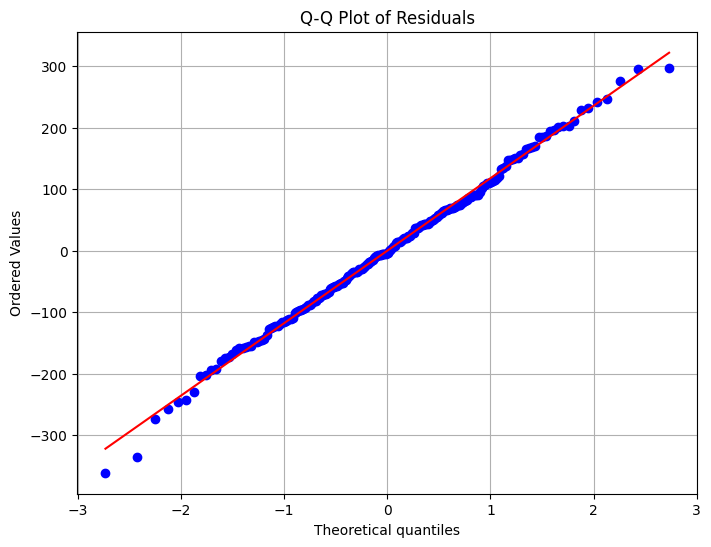

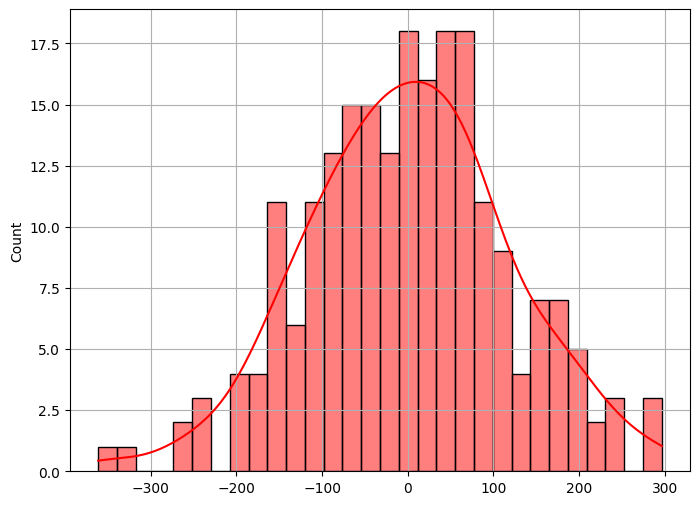

In [34]:
check_residuals_assumptions(model_final_fit)

model_order_1
Durbin-Watson Statistic: 0.35
Breusch-Pagan Test: p-value = 0.0002
Shapiro-Wilk Test: p-value = 0.0106


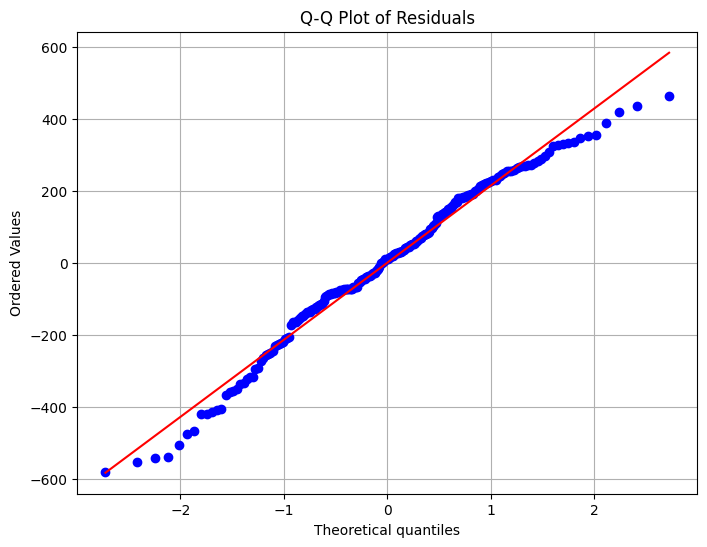

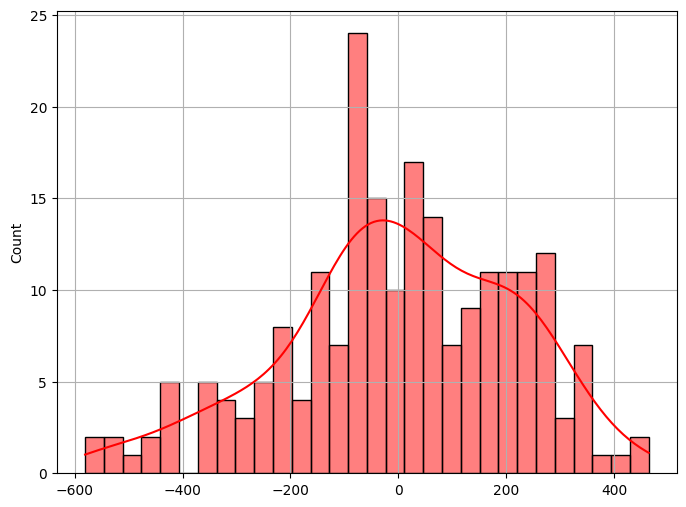

model_order_2
Durbin-Watson Statistic: 0.36
Breusch-Pagan Test: p-value = 0.0171
Shapiro-Wilk Test: p-value = 0.0102


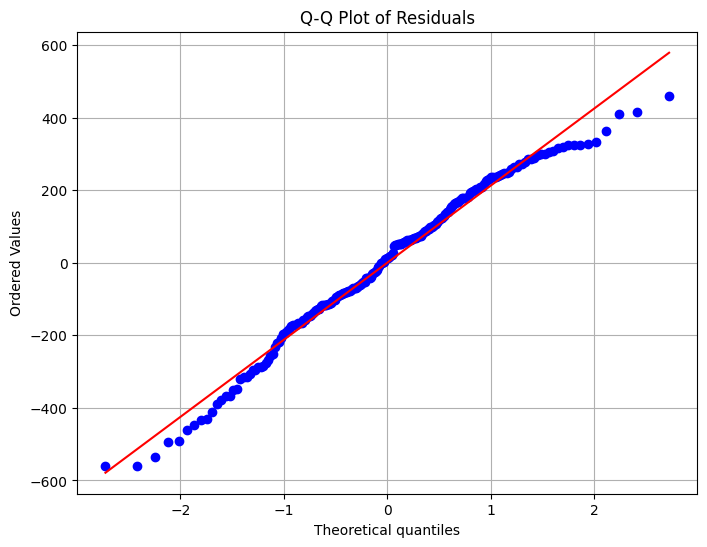

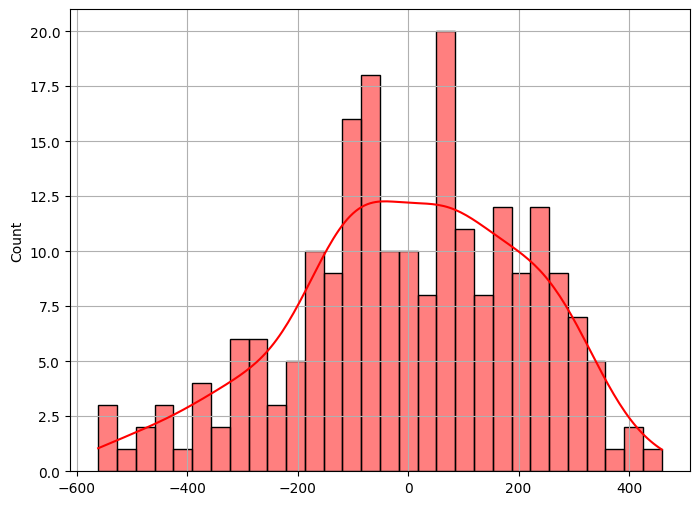

model_order_3
Durbin-Watson Statistic: 0.75
Breusch-Pagan Test: p-value = 0.0045
Shapiro-Wilk Test: p-value = 0.2401


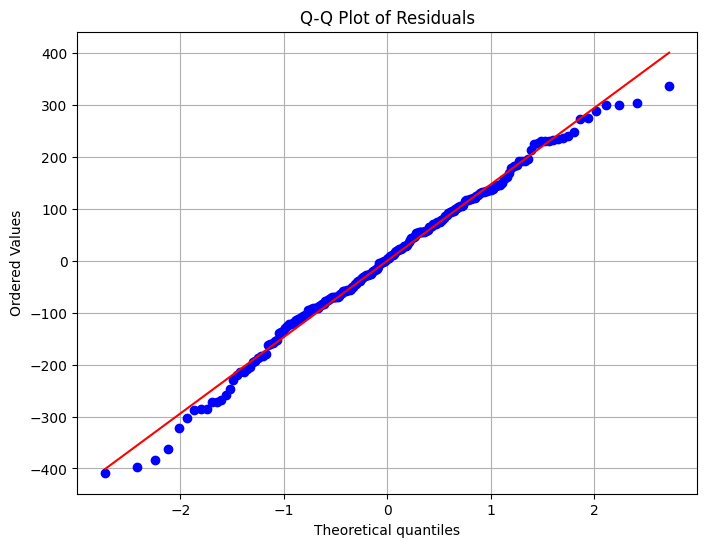

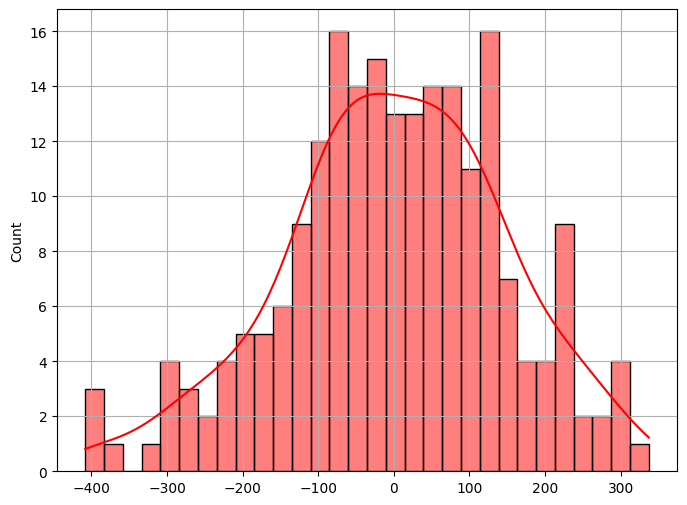

model_order_4
Durbin-Watson Statistic: 1.00
Breusch-Pagan Test: p-value = 0.0085
Shapiro-Wilk Test: p-value = 0.4709


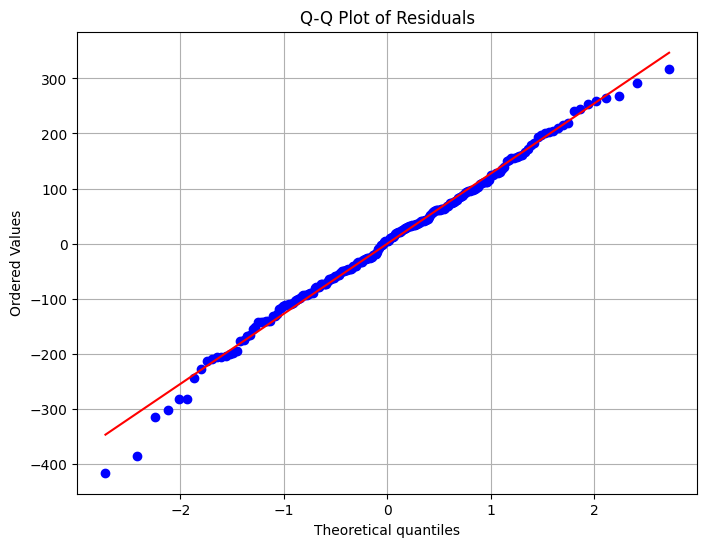

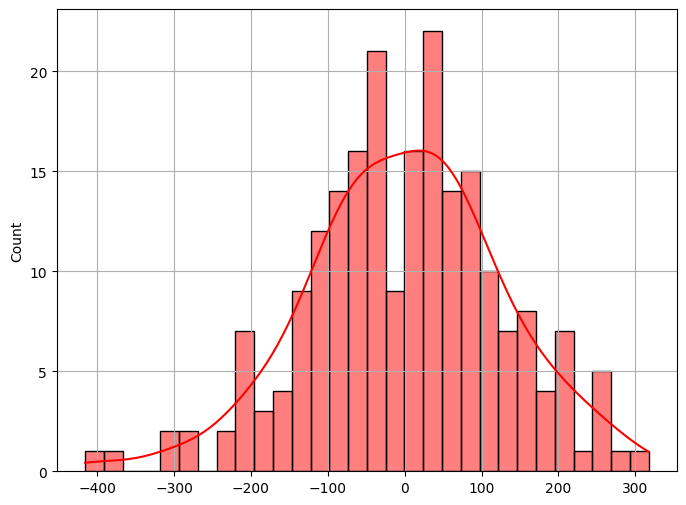

model_order_5
Durbin-Watson Statistic: 1.16
Breusch-Pagan Test: p-value = 0.0136
Shapiro-Wilk Test: p-value = 0.9315


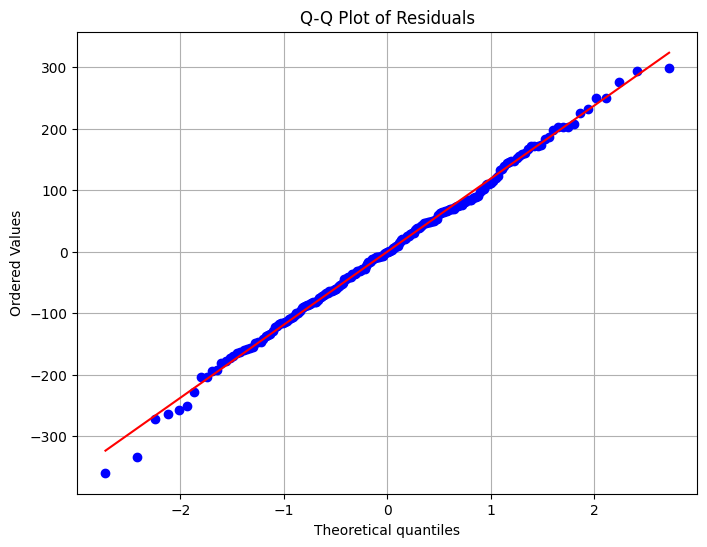

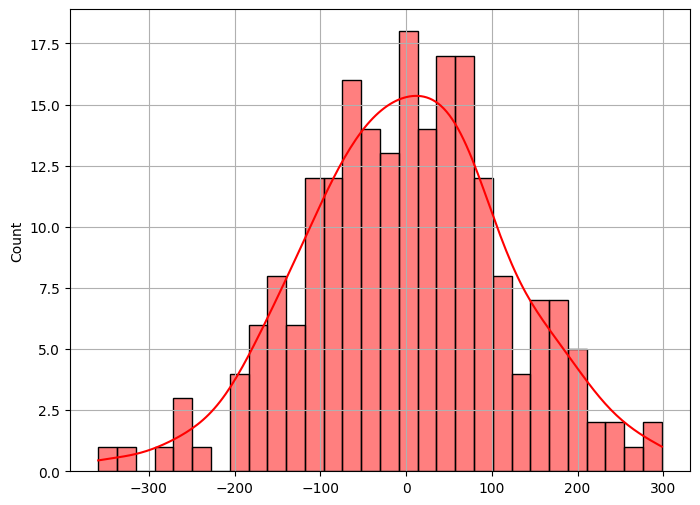

model_order_6
Durbin-Watson Statistic: 1.23
Breusch-Pagan Test: p-value = 0.0065
Shapiro-Wilk Test: p-value = 0.4336


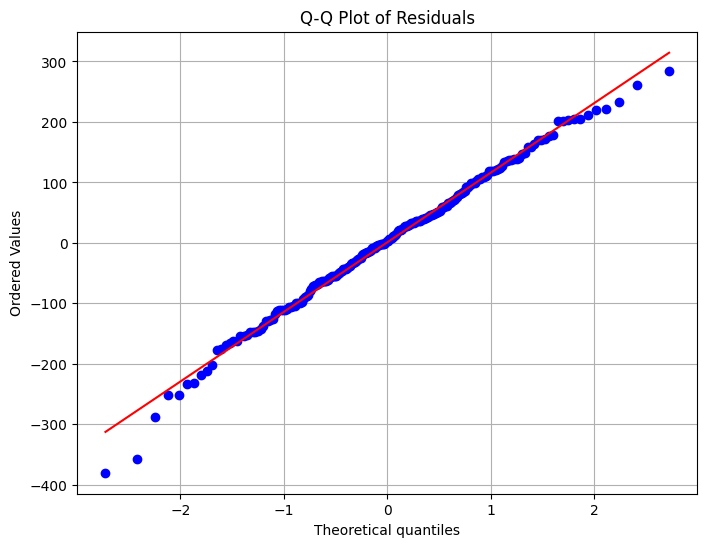

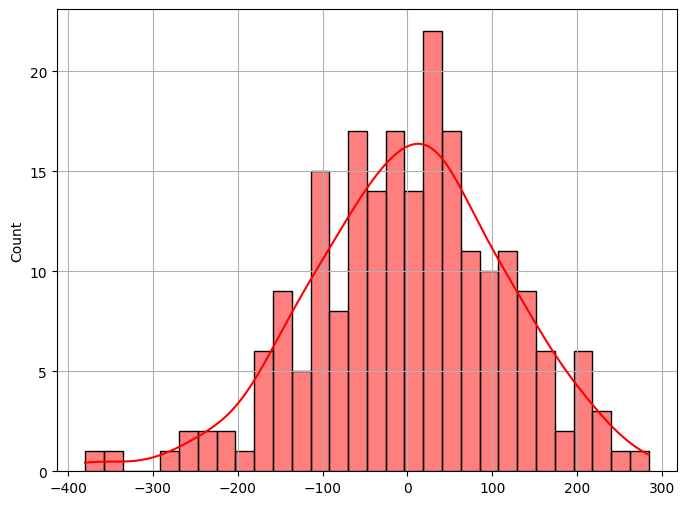

In [35]:
# check all models

for index, model in fitted_models.items():
    print('=======================================')
    print(index)
    check_residuals_assumptions(model)

# 9. Comparación del modelo de este ejercicio Vs. Mejor modelo del taller anterio

# 10. Conclusiones y Limitaciones